In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomRotation, RandomFlip, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import MobileNetV2


import pathlib

In [3]:
train_url = './data/train/'
valid_url = './data/valid/'
test_url = './data/test/'

train_data_dir = pathlib.Path(train_url).with_suffix('')
valid_data_dir = pathlib.Path(test_url).with_suffix('')
test_data_dir = pathlib.Path(valid_url).with_suffix('')

train_image_count = len(list(train_data_dir.glob('*/*.jpg')))
valid_image_count = len(list(valid_data_dir.glob('*/*.jpg')))
test_image_count = len(list(test_data_dir.glob('*/*.jpg')))

print(f'Počet trénovacích obrázků: {train_image_count}')
print(f'Počet validačních obrázků: {valid_image_count}')
print(f'Počet testovacích obrázků: {test_image_count}')

Počet trénovacích obrázků: 4720
Počet validačních obrázků: 165
Počet testovacích obrázků: 165


In [3]:
batch_size = 64
img_height = 64
img_width = 64

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    seed=0,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    valid_data_dir,
    seed=0,
    color_mode='rgb',
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 4720 files belonging to 33 classes.
Found 165 files belonging to 33 classes.


In [6]:
class_names = train_ds.class_names
print(class_names)

['archery', 'baseball', 'basketball', 'billiards', 'bmx', 'bowling', 'boxing', 'bull riding', 'cheerleading', 'curling', 'fencing', 'figure skating', 'football', 'formula 1 racing', 'golf', 'high jump', 'hockey', 'horse racing', 'hydroplane racing', 'judo', 'motorcycle racing', 'pole dancing', 'rugby', 'ski jumping', 'snow boarding', 'speed skating', 'surfing', 'swimming', 'table tennis', 'tennis', 'track bicycle', 'volleyball', 'weightlifting']


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]        

print(np.min(first_image), np.max(first_image))

Model

In [ ]:
classes_len = len(class_names)
print(classes_len)

efficientnet = EfficientNetB3(
    input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet", classes=classes_len
)
efficientnet.trainable = True
model = Sequential()
model.add(efficientnet)
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(256, activation="leaky_relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="leaky_relu"))
model.add(Dropout(0.1))
model.add(Dense(classes_len, activation="softmax"))

model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

In [ ]:
tf.saved_model.save(model, "my_efficientnet_model")

In [ ]:
from tensorflow.keras.preprocessing import image
loaded_model = tf.saved_model.load("my_efficientnet_model")
for i in range(1, 6):
    img_url = './data/test/hydroplane racing/' + str(i) + '.jpg'
    img = image.load_img(img_url, target_size=(img_height, img_width))
    imgShow = image.load_img(img_url)

    # Convert the image to an array and expand dimensions
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    images = np.vstack([X])

    # Perform inference using the model
    val = loaded_model.predict(images, verbose=0)
    index = np.where(val == 1)[1]
    print(val)
    

    predicted_class_index = np.argmax(val)

    # Get the corresponding class label
    predicted_class_label = class_names[predicted_class_index]

    # Join class labels into a comma-separated string
    class_labels_string = ", ".join(class_names)

    # Print the predicted class label and the comma-separated list of all class labels
    print("Predicted class label:", predicted_class_label)
    print((class_names[np.argmax(val)], 100 * np.max(val)))
    # Display the vignette image
    plt.imshow(imgShow)
    plt.show()

Loading Model

In [4]:
loaded_model = tf.saved_model.load("my_efficientnet_model")

class_names = ['archery', 'baseball', 'basketball', 'billiards', 'bmx', 'bowling', 'boxing', 'bull riding', 'cheerleading', 'curling', 'fencing', 'figure skating', 'football', 'formula 1 racing', 'golf', 'high jump', 'hockey', 'horse racing', 'hydroplane racing', 'judo', 'motorcycle racing', 'pole dancing', 'rugby', 'ski jumping', 'snow boarding', 'speed skating', 'surfing', 'swimming', 'table tennis', 'tennis', 'track bicycle', 'volleyball', 'weightlifting']

Jedná se o table tennis s pravděpodobností: 96.0 %


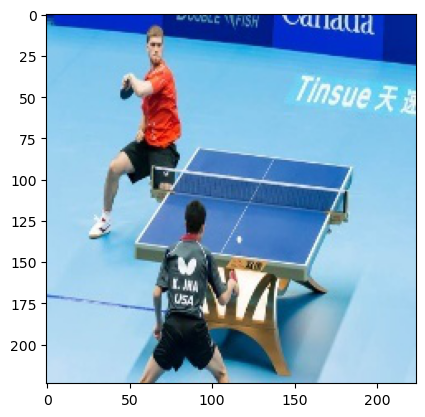

Jedná se o tennis s pravděpodobností: 72.0 %


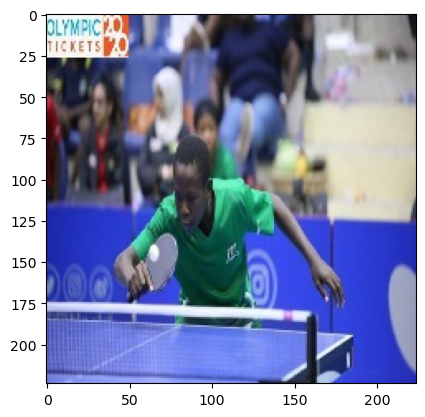

Jedná se o volleyball s pravděpodobností: 34.0 %


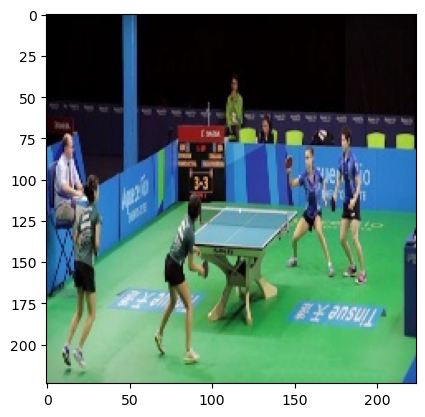

Jedná se o table tennis s pravděpodobností: 99.0 %


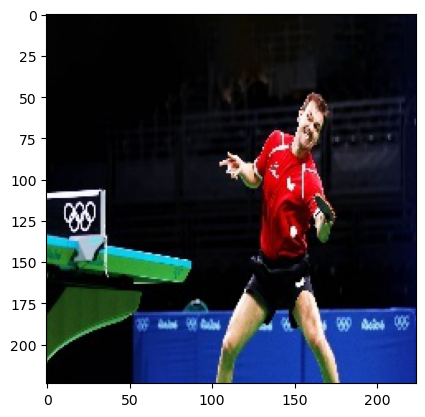

Jedná se o table tennis s pravděpodobností: 99.0 %


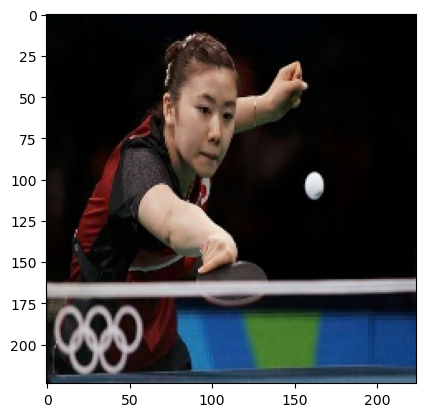

In [8]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the SavedModel
classes_len = len(class_names)

for i in range(1, 6):
    img_url = './data/test/table tennis/' + str(i) + '.jpg'
    img = image.load_img(img_url, target_size=(img_height, img_width))
    img_show = image.load_img(img_url)

    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)

    # Perform inference using the model
    prediction = loaded_model(X)
    
    # Get the predicted class index
    predicted_class_index = tf.argmax(prediction, axis=1).numpy()[0]

    # Get the corresponding class label
    predicted_class_label = class_names[predicted_class_index]

    # Print the predicted class label
    print("Jedná se o", predicted_class_label, "s pravděpodobností:", 100 * np.max(prediction)//1, "%")

    # Display the image
    plt.imshow(img_show)
    plt.show()



In [ ]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(train_ds, val_ds))

In [ ]:
import os
import shutil 

def delete_folders_with_name(root_folder, folder_name_to_delete):
    folder_path = os.path.join(root_folder, folder_name_to_delete)
    try:
        shutil.rmtree(folder_path)
        print(f"Deleted folder: {folder_path}")
    except Exception as e:
        print(f"Error deleting folder: {folder_path} - {e}")

root_folder_train = './data/train/'
root_folder_test = './data/test/'
root_folder_valid = './data/valid/'
folder_name_to_delete = 'cricket'

if os.path.exists(root_folder_train):
    #confirm = input(f"Are you sure you want to delete all '{folder_name_to_delete}' folders in {root_folder}? (y/n): ").strip().lower()
    delete_folders_with_name(root_folder_train, folder_name_to_delete)
    delete_folders_with_name(root_folder_test, folder_name_to_delete)
    delete_folders_with_name(root_folder_valid, folder_name_to_delete)
    print(f"All '{folder_name_to_delete}' folders have been deleted.")
else:
    print("The specified root folder does not exist.")